# Импорт используемых библиотек.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import cross_validate, cross_val_predict, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Загрузка данных.

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/')
root_path = 'gdrive/My Drive/' 

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
!pip install pyxlsb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Загрузка excel-файлов
data = pd.read_excel('/content/gdrive/MyDrive/Training.xlsb', index_col='ID')
test_data = pd.read_excel('/content/gdrive/MyDrive/Test.xlsb', index_col='ID')

In [ ]:
data.head()

,A,B,C,D,E,F,G,H,I,J,...,P,Q,R,S,T,U,V,W,X,MARKER
ID,,,,,,,,,,,,,,,,,,,,,
1,0.198778,0.099389,0.00,799.90,1.777556,0.888778,13,3.49,Woman,33.750000,...,2 Two,property,No,Works,Yes,Yes,No,Yes,No,0
2,0.043000,0.021264,49.97,173.03,0.384511,0.190143,13,3.49,Woman,33.250000,...,2 Two,otherwise,No,Works,Yes,Yes,Yes,Yes,No,0
3,0.067073,0.067073,0.00,329.90,0.599818,0.599818,13,3.49,Woman,38.583333,...,1 One,property,No,No couple,No,Yes,No,Yes,No,0
4,0.052700,0.052700,0.00,235.65,0.471300,0.471300,13,3.49,Woman,61.250000,...,0 Zero,property,No,No couple,Yes,Yes,Few,Yes,No,0
5,0.141880,0.141880,0.00,634.45,1.268900,1.268900,13,3.49,Woman,48.583333,...,0 Zero,property,No,No couple,Yes,No,No,No,No,0


In [ ]:
test_data.head()

,A,B,C,D,E,F,G,H,I,J,...,P,Q,R,S,T,U,V,W,X,MARKER
ID,,,,,,,,,,,,,,,,,,,,,
1,0.085400,0.085400,29.72,267.28,0.763657,0.763657,13,3.49,Woman,23.500000,...,1 One,property,No,No couple,Yes,Yes,No,No,No,0
2,0.223218,0.111609,0.00,1097.90,1.996182,0.998091,13,3.49,Woman,34.916667,...,3 Three,property,No,Works,Yes,Yes,No,No,No,1
3,0.048400,0.048400,0.00,399.90,0.499875,0.499875,13,1.99,Man,41.750000,...,0 Zero,property,No,Unemployed,Yes,Yes,No,No,No,0
4,0.039560,0.039560,19.59,176.93,0.353860,0.353860,13,3.49,Man,33.083333,...,1 One,property,No,Unemployed,Yes,Yes,Yes,Yes,No,0
5,0.231017,0.173263,0.00,1239.56,2.065933,1.549450,13,3.49,Woman,44.833333,...,1 One,property,No,Works,Yes,Yes,No,No,No,0


# EDA.

**Проверка размеров датасетов.**





In [ ]:
print(f'Размер тренировочного датасета {data.shape[0]} строк и {data.shape[1]} столбцов.')
print(f'Размер тестового датасета {test_data.shape[0]} строк и {test_data.shape[1]} столбцов.')

Размер тренировочного датасета 89734 строк и 25 столбцов.
Размер тестового датасета 38405 строк и 25 столбцов.


**Проверка наличия дублированных записей.**

In [ ]:
print(f'Количество дублированных записей в тренировочном датасете {data.duplicated().sum()}.')
print(f'Количество дублированных записей в тестовом датасете {test_data.duplicated().sum()}.')

Количество дублированных записей в тренировочном датасете 0.
Количество дублированных записей в тестовом датасете 0.


**Поиск пропущенных значений.**

In [ ]:
columns = data.columns

In [ ]:
missing_train = []
missing_test = []

for col, per_train, per_test in zip(columns, data.isnull().mean()*100, test_data.isnull().mean()*100):
  if per_train!=0.0:
    missing_train.append(col)
  if per_train!=0.0:
    missing_test.append(col)

if missing_train==[]:
  print('В тренировочном датасете нет пропущенных значений.')
else:
  print(f'В тренировочном датасете {len(missing_train)} колонок, в которых есть пропущенных значений.')
if missing_test==[]:
  print('В тестовом датасете нет пропущенных значений.')
else:
  print(f'В тестовом датасете {len(missing_test)} колонок, в которых есть пропущенных значений.')

В тренировочном датасете нет пропущенных значений.
В тестовом датасете нет пропущенных значений.


**Изучение типа данных переменных.**

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89734 entries, 1 to 89734
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       89734 non-null  float64
 1   B       89734 non-null  float64
 2   C       89734 non-null  float64
 3   D       89734 non-null  float64
 4   E       89734 non-null  float64
 5   F       89734 non-null  float64
 6   G       89734 non-null  int64  
 7   H       89734 non-null  float64
 8   I       89734 non-null  object 
 9   J       89734 non-null  float64
 10  K       89734 non-null  object 
 11  L       89734 non-null  int64  
 12  M       89734 non-null  object 
 13  N       89734 non-null  object 
 14  O       89734 non-null  object 
 15  P       89734 non-null  object 
 16  Q       89734 non-null  object 
 17  R       89734 non-null  object 
 18  S       89734 non-null  object 
 19  T       89734 non-null  object 
 20  U       89734 non-null  object 
 21  V       89734 non-null  object 
 22

In [ ]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38405 entries, 1 to 38405
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       38405 non-null  float64
 1   B       38405 non-null  float64
 2   C       38405 non-null  float64
 3   D       38405 non-null  float64
 4   E       38405 non-null  float64
 5   F       38405 non-null  float64
 6   G       38405 non-null  int64  
 7   H       38405 non-null  float64
 8   I       38405 non-null  object 
 9   J       38405 non-null  float64
 10  K       38405 non-null  object 
 11  L       38405 non-null  int64  
 12  M       38405 non-null  object 
 13  N       38405 non-null  object 
 14  O       38405 non-null  object 
 15  P       38405 non-null  object 
 16  Q       38405 non-null  object 
 17  R       38405 non-null  object 
 18  S       38405 non-null  object 
 19  T       38405 non-null  object 
 20  U       38405 non-null  object 
 21  V       38405 non-null  object 
 22

Признаки типа float64 и int64 оставляем без изменения. Это колонки  A, B, C, D, E, F, G, H, J, L и предсказываемая переменная MARKER.

Имеются категориальные переменные типа object, для которых необходиа предрбработка. Это колонки I, K, M, N, O, P, Q, R, S, T, U, V, W, X. Исследуем каждую из них.

Для начала проверим совпадают ли  категориальные переменные и их количество в тренировочном и тестовом датасетах.

In [ ]:
cat_cols = ['I', 'K', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X']
for col in cat_cols:
  if sorted(data[col].unique()) == sorted(test_data[col].unique()):
    print(f'Колонка {col} имеет уникальных значений {len(data[col].unique())}: {sorted(data[col].unique())}.')
  else:
    print(f'Колонка {col} в тренировочном датасете имеет {len(data[col].unique())} уникальных значений: {sorted(data[col].unique())},\
          а в тестовом {len(test_data[col].unique())} уникальных значений: {sorted(test_data[col].unique())}.')

Колонка I имеет уникальных значений 2: ['Man', 'Woman'].
Колонка K имеет уникальных значений 7: ['Brest region', 'Gomel region', 'Grodno region', 'Minsk', 'Minsk region', 'Mogilev region', 'Vitebsk region'].
Колонка M имеет уникальных значений 5: ['Enterpreneur', 'Head/Deputy head (division)', 'Head/Deputy head (organiz.)', 'NE employee', 'Pensioner'].
Колонка N имеет уникальных значений 4: ['Higher education (one or more)', 'Incomplete higher education', 'Primary or lower secondary education', 'Secondary education (plus special education)'].
Колонка O имеет уникальных значений 4: ['Cohabitation', 'Divorced/widow', 'Married', 'Single/unmarried'].
Колонка P имеет уникальных значений 5: ['0 Zero', '1 One', '2 Two', '3 Three', 'More than 3'].
Колонка Q имеет уникальных значений 3: ['otherwise', 'property', 'rent/hire'].
Колонка R имеет уникальных значений 2: ['No', 'Yes'].
Колонка S имеет уникальных значений 5: ['No couple', 'Pensioner', 'Student', 'Unemployed', 'Works'].
Колонка T имеет 

Все переменные совпадают. 

Признаки колонки "P" уже можно заменить на числа.



In [ ]:
for p in data['P'].unique():
  if p=='More than 3':
    data.loc[(data.P == p), 'P'] = 4
    test_data.loc[(test_data.P == p), 'P'] = 4
  else:
    data.loc[(data.P == p), 'P'] = int(p[0])
    test_data.loc[(test_data.P == p), 'P'] = int(p[0])
data['P'] = data['P'].astype(int)
test_data['P'] = test_data['P'].astype(int)

In [ ]:
cat_cols.remove('P')

**Изучение сводных статистических данных для каждой переменной.**

Для числовых данные построим box plot.

In [ ]:
cont_cols = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'L', 'P']

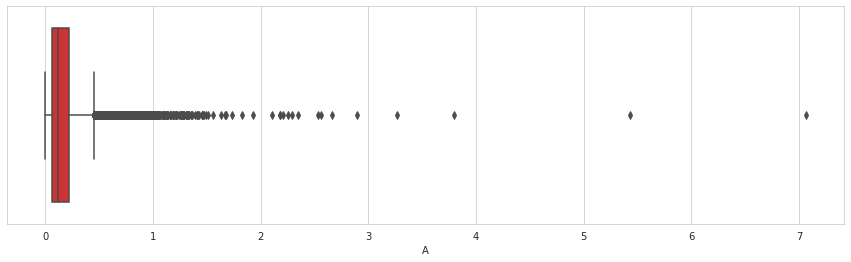

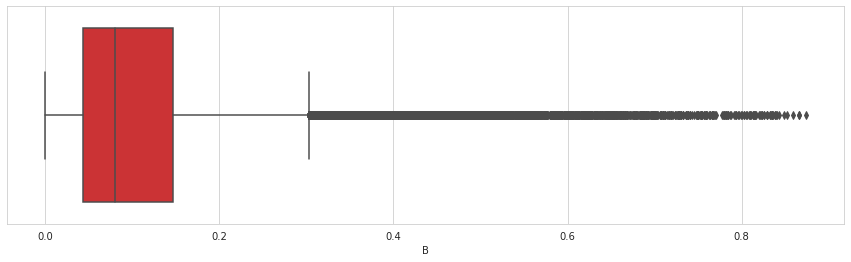

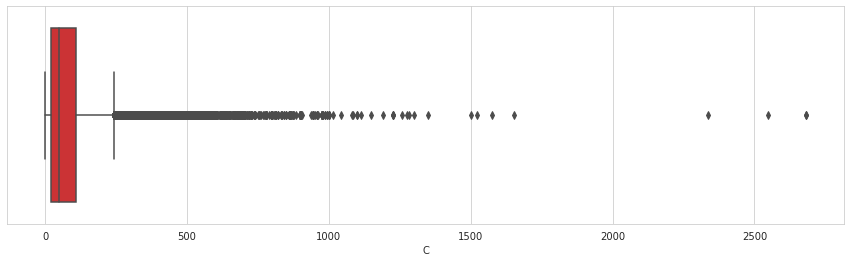

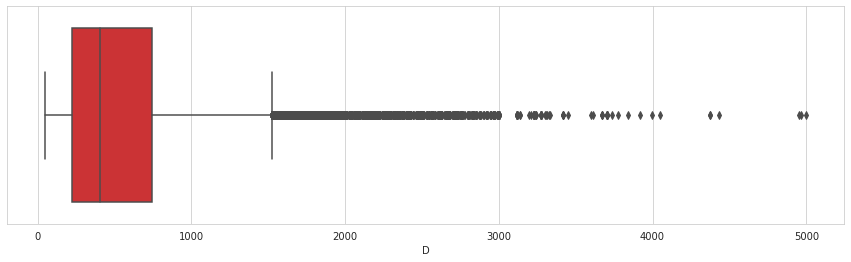

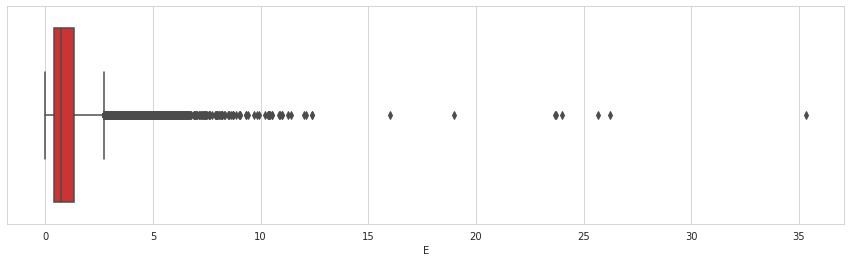

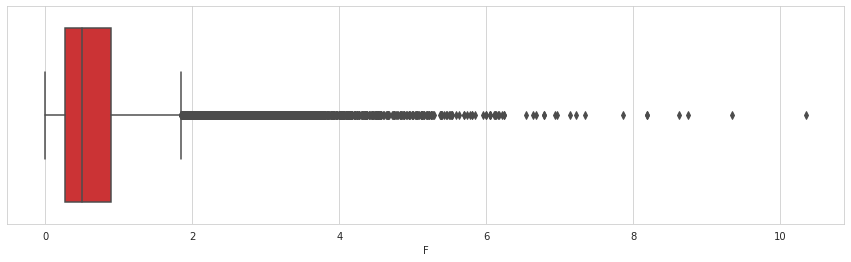

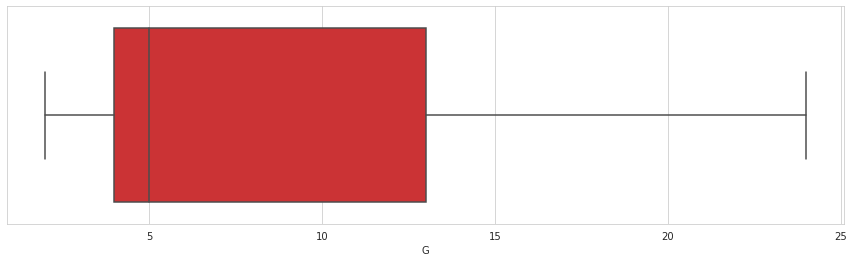

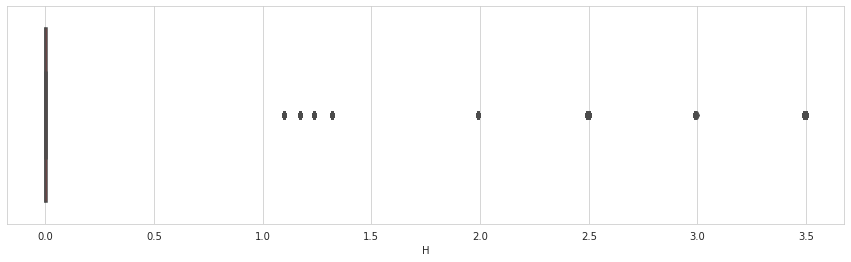

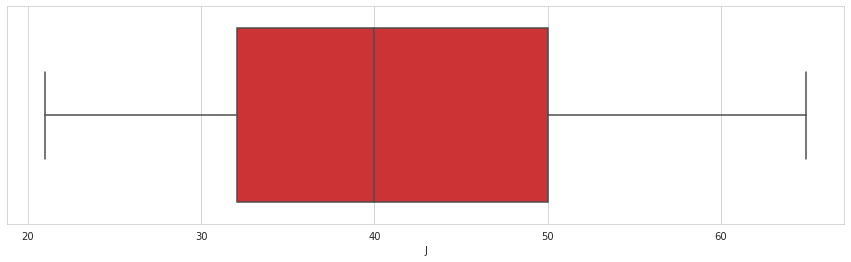

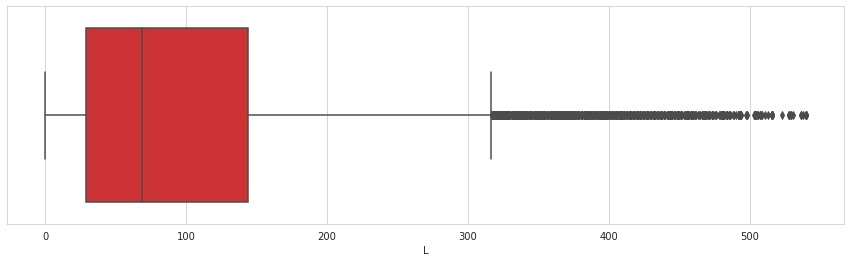

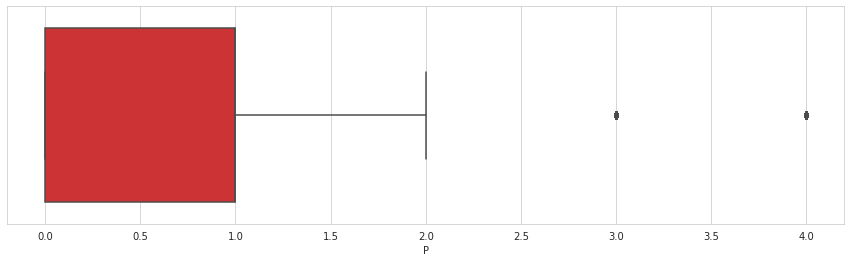

In [ ]:
sns.set_style(style='whitegrid')
for col in cont_cols:
    plt.figure(figsize=(15,4))
    sns.boxplot(x = data[col], palette="Set1")
    plt.show()

Из данных диаграмм видно, что почти все переменные имеют некоторое количество выбросов. Это стоит учесть при выборе модели обучения.

Для категориальных признаков посмотроим гистограммы.

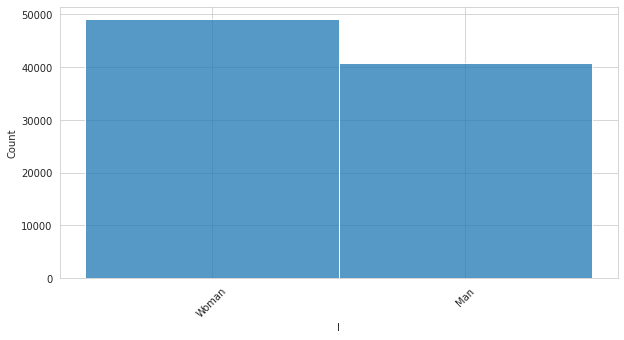

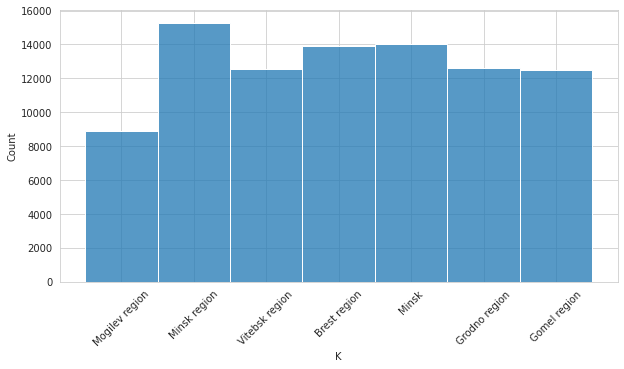

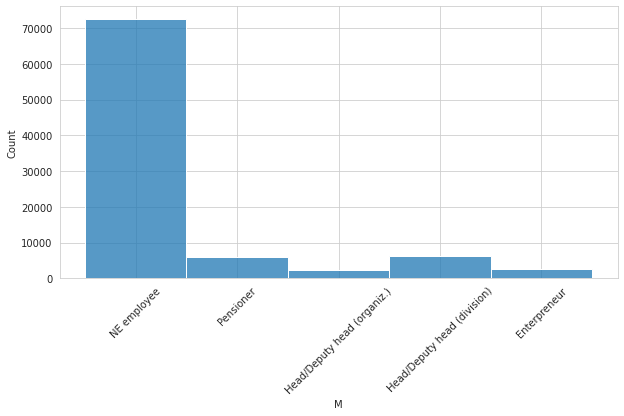

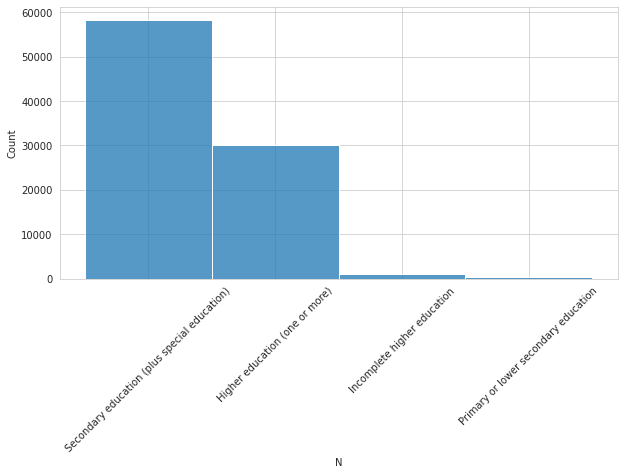

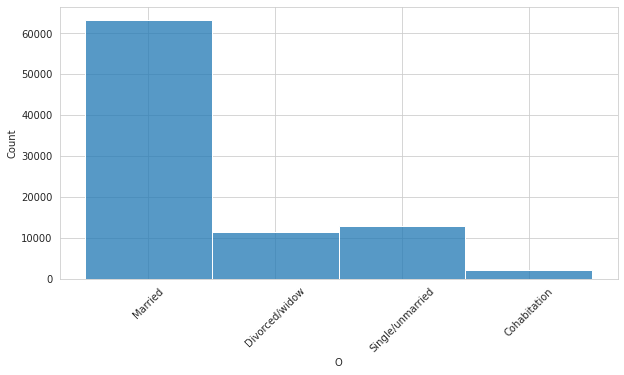

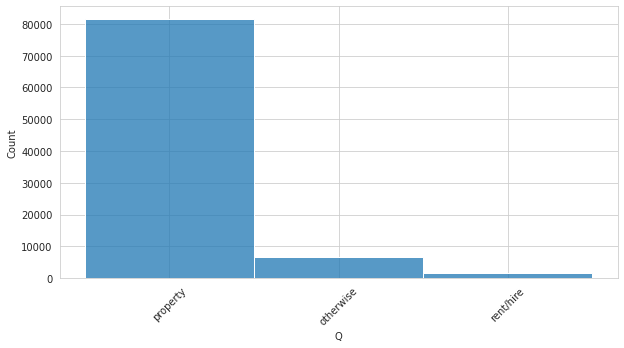

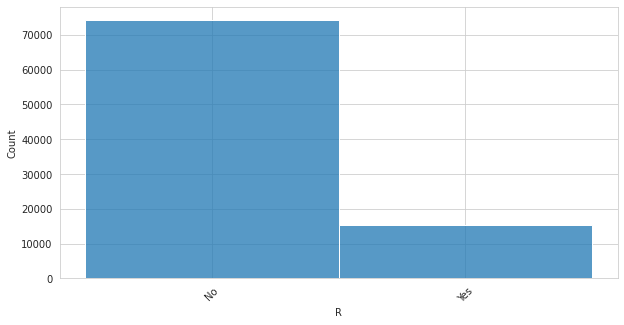

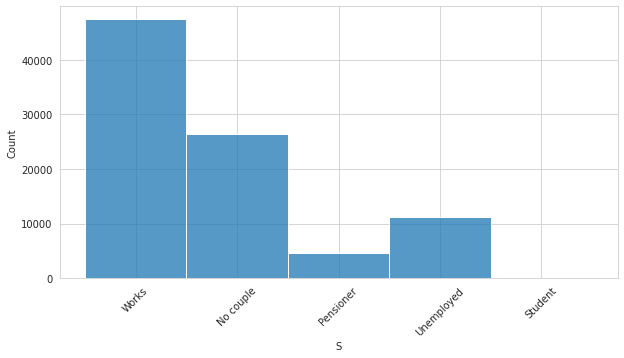

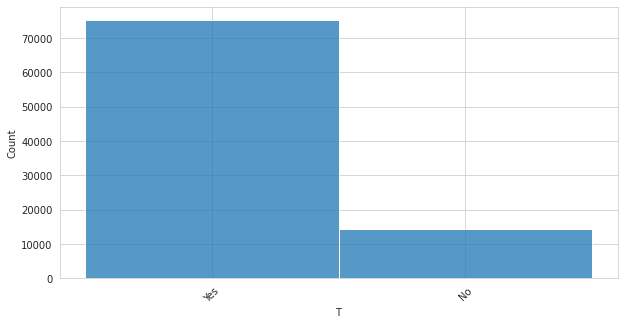

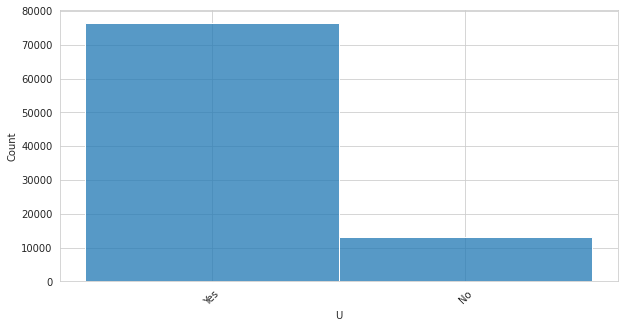

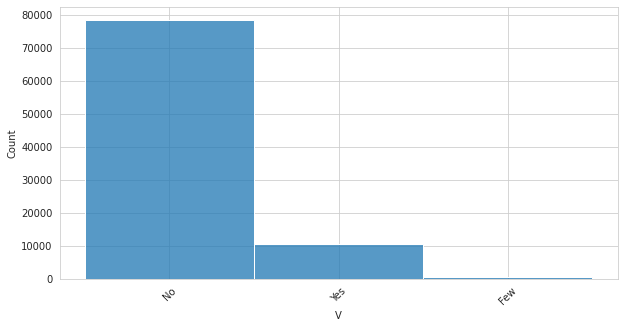

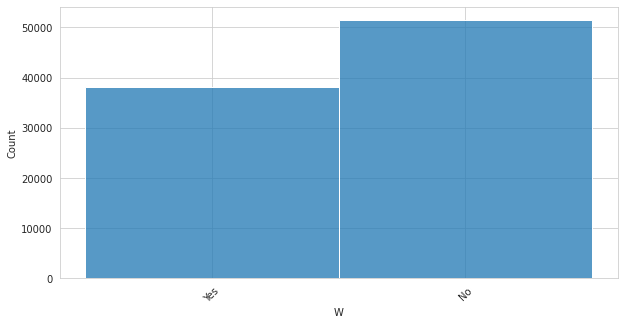

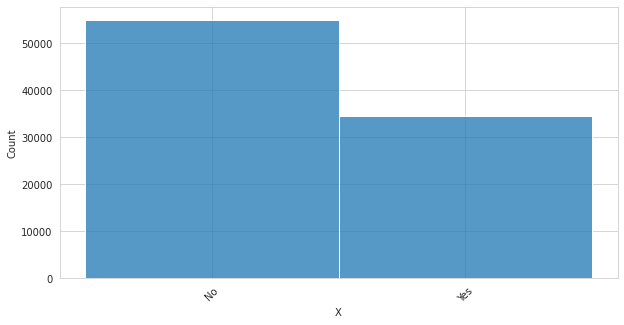

In [ ]:
for col in cat_cols:
  plt.figure(figsize=(10,5))
  sns.histplot(x = data[col])
  plt.xticks(rotation=45)
  plt.show()

Для некоторых признаков, есть перевес в сторону определенных категорий. 

**Категориальные признаки.**

Теперь кодируем категориальные переменные.

In [ ]:
LE = LabelEncoder()
le_count = 0
for col in cat_cols:
  if len(data[col].unique()) <= 2:
    LE.fit(data[col])
    data[col] = LE.transform(data[col])
    test_data[col] = LE.transform(test_data[col])
  else:
    data = pd.get_dummies(data, columns=[col], drop_first = True)
    test_data = pd.get_dummies(test_data, columns=[col], drop_first = True)

**Исследование целевой переменной.**

0    89392
1      342
Name: MARKER, dtype: int64

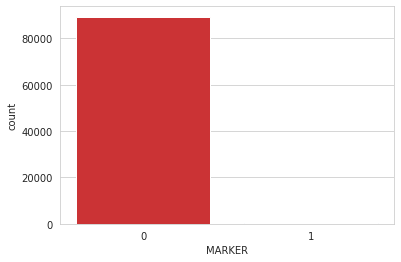

In [ ]:
sns.countplot(x = data['MARKER'], palette="Set1")
data.MARKER.value_counts()

Значение целевой переменной равное 1 встречаеется в более чем 100 раз реже, чем равное 0, что говорит о сильном дисбалансе классов. Таким образом получаем, что accyracy для оценки качества модели лучше не исспользовать (лучшим выбором будет F1-score или ROC AUC).

# Выбор признаков.

**Построение матрицы корреляции.**

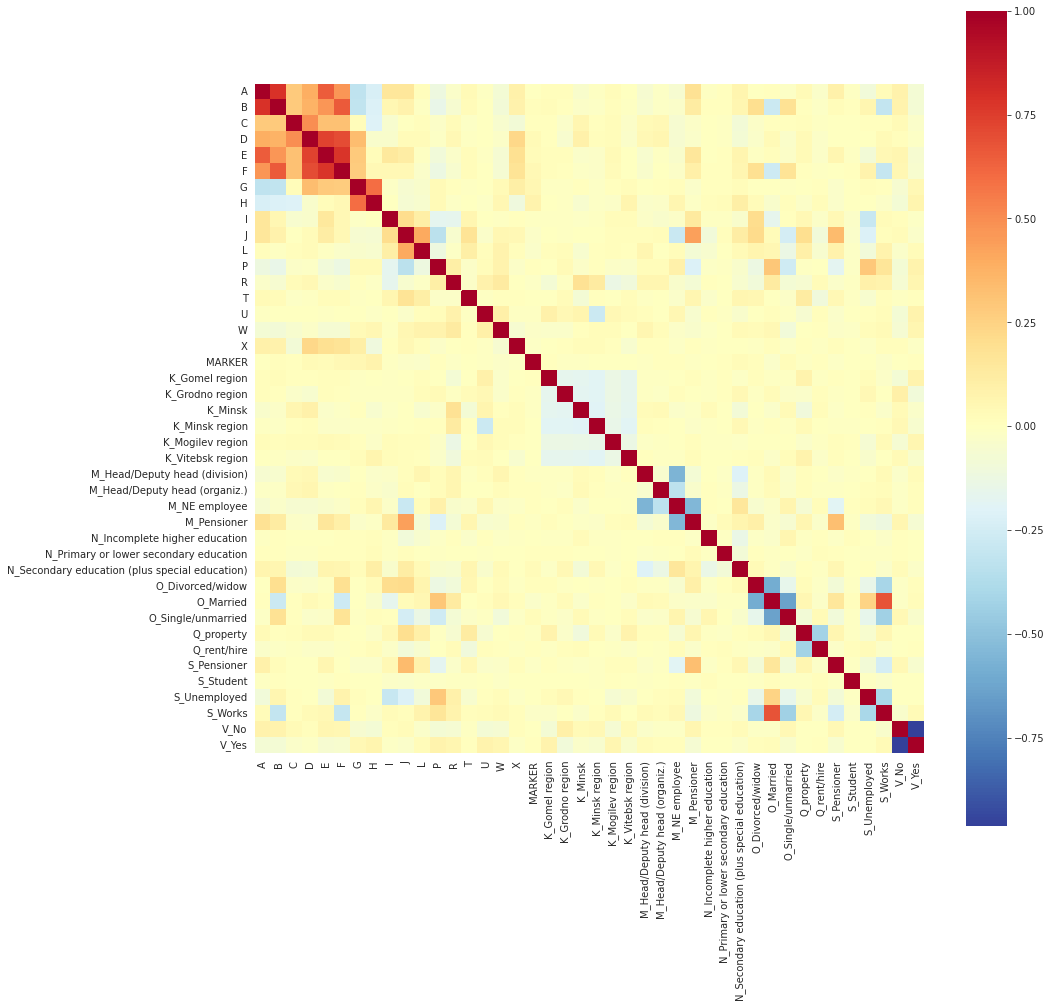

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(data.corr(method='pearson'), center=0, square=True, cmap = plt.cm.RdYlBu_r)
plt.show()

In [ ]:
correlation_matrix = data.corr(method = 'pearson')
corr_col = {}
corr_columns = correlation_matrix.columns[:-1]
for i in range(len(corr_columns)):
  col = corr_columns[i]
  cols = corr_columns[:(i+1)]  
  corr_list = correlation_matrix[col][(i+1):][np.abs(correlation_matrix[col][(i+1):])>0.9].index.tolist()
  if corr_list!=[]:
    corr_col[col] = corr_list
corr_col

{'V_No': ['V_Yes']}

In [ ]:
data = data.drop(columns='V_Yes')
test_data = test_data.drop(columns='V_Yes')

**Признаки, с неизменными значениями.**

In [ ]:
y_train, X_train = data['MARKER'], data.drop(columns='MARKER')
y_test, X_test = test_data['MARKER'], test_data.drop(columns='MARKER')

In [ ]:
data.shape

(89734, 41)

In [ ]:
selector = VarianceThreshold()
selector.fit_transform(X_train)
print(X_train.shape)

(89734, 40)


Был удален 1 признак. Теперь удалим его в тестовом датасете.

In [ ]:
for col in X_test.columns:
  if col not in X_train.columns:
    X_test = X_test.drop(columns=col)
X_test.shape[1] == X_train.shape[1]

True

# Построение модели обучения.

Имеем задачу бинарной классификации с дисбалансом данных (0 >> 1).

Для оценки качества модели будем исспользовать ROC AUC (площадь под кривой ошибок).

Для борьбы с дисбалансом классов используем SMOTE.

In [ ]:
SM = SMOTE(random_state=20)
X_train_SM, y_train_SM = SM.fit_resample(X_train, y_train)

Исспользуем StandardScaler() для нормализации данных.

In [ ]:
scaler = StandardScaler()
X_train_SM_scaled = scaler.fit_transform(X_train_SM)
X_test_scaled = scaler.transform(X_test)

Применим метод снижения размерности признакового пространства TruncatedSVD. Количество признаков выбрираем равным 2. Исспользовать будем отскалированные данные.

In [ ]:
T_svd = TruncatedSVD(n_components = 2, random_state = 20)
X_train_tsvd = T_svd.fit_transform(X_train_SM_scaled)
X_test_tsvd = T_svd.fit_transform(X_test_scaled)

**LogisticRegression.**

Подбор параметров модели.

In [ ]:
CV_model = GridSearchCV(estimator=LogisticRegression(solver='saga',random_state=20), 
                            param_grid={'penalty': ['l1', 'l2'],
                                        'C': [0.0001,0.001,0.01,0.1,1],
                                },
                            cv=5, 
                            scoring='roc_auc',
                            n_jobs=-1)
CV_model.fit(X_train_tsvd, y_train_SM)
print(CV_model.best_params_)

{'C': 0.001, 'penalty': 'l2'}


Обучение лучшей модели LogisticRegression.

In [ ]:
model_LR = LogisticRegression(C=0.001, penalty = 'l2', solver='saga',random_state=20)
model_LR.fit(X_train_tsvd, y_train_SM)

results = cross_validate(model_LR, X_train_tsvd, y_train_SM, cv=5, return_train_score=True, scoring='roc_auc')

y_train_pred = model_LR.predict_proba(X_train_tsvd)[:,1]
y_test_pred = model_LR.predict_proba(X_test_tsvd)[:,1]
train_roc_auc = roc_auc_score(y_train_SM, y_train_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred)

print(f'ROC AUC train = {train_roc_auc}')
print(f'ROC AUC test = {test_roc_auc}')

ROC AUC train = 0.9499060515069501
ROC AUC test = 0.8167192820956803


**KNeighborsClassifier.**

Подбор параметров модели.

In [ ]:
CV_model = GridSearchCV(estimator=KNeighborsClassifier(), 
                            param_grid={'n_neighbors': np.arange(2, 40),
                                },
                            cv=5, 
                            scoring='roc_auc',
                            n_jobs=-1)

CV_model.fit(X_train_tsvd, y_train_SM);
print(CV_model.best_params_)

{'n_neighbors': 35}


Обучение лучшей модели KNeighborsClassifier.

In [ ]:
model_KNN = KNeighborsClassifier(n_jobs=-1, n_neighbors=35)
model_KNN.fit(X_train_tsvd, y_train_SM)

results = cross_validate(model_KNN, X_train_tsvd, y_train_SM, cv=5, return_train_score=True, scoring='roc_auc')

y_train_pred = model_KNN.predict_proba(X_train_tsvd)[:, 1]
y_test_pred = model_KNN.predict_proba(X_test_tsvd)[:, 1]
train_roc_auc = roc_auc_score(y_train_SM, y_train_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred)

print(f'ROC AUC train = {train_roc_auc}')
print(f'ROC AUC  test = {test_roc_auc}')

ROC AUC train = 0.9662115158244496
ROC AUC  test = 0.7766893061602123


**RandomForestClassifier.**

Подбор параметров модели.

In [ ]:
CV_model = GridSearchCV(estimator=RandomForestClassifier(random_state=20), 
                            param_grid={'n_estimators': np.arange(10, 200, 10),
                                        'max_depth': np.arange(1, 40),
                                },
                            cv=5, 
                            scoring='roc_auc',
                            n_jobs=-1)
CV_model.fit(X_train_tsvd, y_train_SM);
print(CV_model.best_params_)

{'max_depth': 18, 'n_estimators': 190}


Обучение лучшей модели RandomForestClassifier.

In [ ]:
model_RFC = RandomForestClassifier(n_estimators=190, max_depth = 18, n_jobs=-1, random_state=20)
model_RFC.fit(X_train_tsvd, y_train_SM)

results = cross_validate(model_RFC, X_train_tsvd, y_train_SM, cv=5, return_train_score=True, scoring='roc_auc')

y_train_pred = model_RFC.predict_proba(X_train_tsvd)[:,1]
y_test_pred = model_RFC.predict_proba(X_test_tsvd)[:,1]
train_roc_auc = roc_auc_score(y_train_SM, y_train_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred)

print(f'ROC AUC train = {train_roc_auc}')
print(f'ROC AUC test = {test_roc_auc}')

ROC AUC train = 0.9947919053539551
ROC AUC test = 0.7809447289150695


**DecisionTreeClassifier.**

Подбор параметров модели.

In [ ]:
CV_model = GridSearchCV(estimator=DecisionTreeClassifier(random_state=20), 
                            param_grid={'max_depth': np.arange(1, 30)
                                },
                            cv=5, 
                            scoring='roc_auc',
                            n_jobs=-1)

CV_model.fit(X_train_tsvd, y_train_SM)
print(CV_model.best_params_)

{'max_depth': 8}


Обучение лучшей модели DecisionTreeClassifier.

In [ ]:
model_DTC = DecisionTreeClassifier(max_depth=8, random_state=20)
model_DTC.fit(X_train_tsvd, y_train_SM)

results = cross_validate(model_DTC, X_train_tsvd, y_train_SM, cv=5, return_train_score=True, scoring='roc_auc')

y_train_pred = model_DTC.predict_proba(X_train_tsvd)[:, 1]
y_test_pred = model_DTC.predict_proba(X_test_tsvd)[:, 1]
train_roc_auc = roc_auc_score(y_train_SM, y_train_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred)

print(f'ROC AUC train = {train_roc_auc}')
print(f'ROC AUC  test = {test_roc_auc}')

ROC AUC train = 0.9577351751046523
ROC AUC  test = 0.7932234227634504


**GradientBoostingClassifier.**

In [ ]:
model_GBC = GradientBoostingClassifier(learning_rate=0.1, n_estimators=200, max_depth=1, random_state=20)
model_GBC.fit(X_train_tsvd, y_train_SM)

results = cross_validate(model_GBC, X_train_tsvd, y_train_SM, cv=5, return_train_score=True, scoring='roc_auc')

y_train_pred = model_GBC.predict_proba(X_train_tsvd)[:,1]
y_test_pred = model_GBC.predict_proba(X_test_tsvd)[:,1]
train_roc_auc = roc_auc_score(y_train_SM, y_train_pred)
test_roc_auc = roc_auc_score(y_test, y_test_pred)

print(f'ROC AUC train = {train_roc_auc}')
print(f'ROC AUC test = {test_roc_auc}')

ROC AUC train = 0.9533715801330823
ROC AUC test = 0.8134685472878259


**Стекинг.**

In [ ]:
def compute_meta_feature(model, X_train, X_test, y_train, cv):
    try:
        train_answers = cross_val_predict(model, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
        model.fit(X_train, y_train)
        return train_answers, model.predict_proba(X_test)[:, 1]
    
    except Exception:
        train_answers = cross_val_predict(model, X_train, y_train, cv=cv, method='predict')
        model.fit(X_train, y_train)
        return train_answers, model.predict(X_test)

In [ ]:
models = []
models.append(KNeighborsClassifier(n_neighbors=5, n_jobs=-1))
models.append(KNeighborsClassifier(n_neighbors=35, n_jobs=-1))
models.append(LogisticRegression(C=0.0001, penalty = 'l1', solver='saga',random_state=20))
models.append(RandomForestClassifier(max_depth=3, n_estimators=60, n_jobs=-1, random_state=20))
models.append(RandomForestClassifier(max_depth=18, n_estimators=190, n_jobs=-1, random_state=20))
models.append(DecisionTreeClassifier(max_depth=3, random_state=20))
models.append(DecisionTreeClassifier(max_depth=8, random_state=20))
models.append(GradientBoostingClassifier(learning_rate=1, n_estimators=100, max_depth=15, random_state=20))

In [ ]:
meta_features_train = np.zeros((X_train_tsvd.shape[0], 0))
meta_features_test = np.zeros((X_test_tsvd.shape[0], 0))

for model in (models):
    train, test = compute_meta_feature(model, X_train_tsvd, X_test_tsvd, y_train_SM, 5)
    meta_features_train = np.append(meta_features_train, train.reshape((train.size, 1)), axis=1)
    meta_features_test = np.append(meta_features_test, test.reshape((test.size, 1)), axis=1)

stacking_model = LogisticRegression(C=0.001, penalty = 'l2', random_state=20)
stacking_model.fit(meta_features_train, y_train_SM)

y_train_predicted = stacking_model.predict_proba(meta_features_train)[:,1]
y_test_predicted = stacking_model.predict_proba(meta_features_test)[:,1]

train_roc_auc = roc_auc_score(y_train_SM, y_train_predicted)
test_roc_auc = roc_auc_score(y_test, y_test_predicted)

print(f'roc_auc-score train = {train_roc_auc}')
print(f'roc_auc-score test = {test_roc_auc}')

roc_auc-score train = 0.9599088295767033
roc_auc-score test = 0.8090684723837923


Лучшая модель для предсказания MARKER - LogisticRegression с параметрами C=0.001, penalty = 'l2', solver='saga'. 

# Запись файла с предсказанными значениями.

In [ ]:
model_LR = LogisticRegression(C=0.001, penalty = 'l2', solver='saga',random_state=20)
model_LR.fit(X_train_tsvd, y_train_SM)
results = cross_validate(model_LR, X_train_tsvd, y_train_SM, cv=5, return_train_score=True, scoring='roc_auc')

y_pred = model_LR.predict(X_test_tsvd)

In [ ]:
y_exel = pd.DataFrame(data = {'ID':test_data.index, 'y_pred':y_pred})

In [ ]:
y_exel

,ID,y_pred
0,1,1
1,2,1
2,3,0
3,4,1
4,5,0
...,...,...
38400,38401,0
38401,38402,0
38402,38403,0
38403,38404,1


In [ ]:
#y_exel.to_excel('/content/gdrive/MyDrive/pred.xlsx')